# Grid box mix Pull back - Backtesting

### Import Library

In [60]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
from backtesting._plotting import set_bokeh_output
set_bokeh_output(notebook=False)

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [61]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [62]:
data = dataset.copy()

In [63]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-11-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [64]:
min(data['Close'])

862.3

In [65]:
max(data['Close'])

1575.6

In [66]:
def generate_grid(bot, top, grid_distance):
    return (np.arange(bot, top, grid_distance))

In [67]:
bot_grid = 860
top_grid = 1575

In [68]:
grid_distance = 5
grid = generate_grid(bot_grid, top_grid, grid_distance)
grid

array([ 860,  865,  870,  875,  880,  885,  890,  895,  900,  905,  910,
        915,  920,  925,  930,  935,  940,  945,  950,  955,  960,  965,
        970,  975,  980,  985,  990,  995, 1000, 1005, 1010, 1015, 1020,
       1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1075,
       1080, 1085, 1090, 1095, 1100, 1105, 1110, 1115, 1120, 1125, 1130,
       1135, 1140, 1145, 1150, 1155, 1160, 1165, 1170, 1175, 1180, 1185,
       1190, 1195, 1200, 1205, 1210, 1215, 1220, 1225, 1230, 1235, 1240,
       1245, 1250, 1255, 1260, 1265, 1270, 1275, 1280, 1285, 1290, 1295,
       1300, 1305, 1310, 1315, 1320, 1325, 1330, 1335, 1340, 1345, 1350,
       1355, 1360, 1365, 1370, 1375, 1380, 1385, 1390, 1395, 1400, 1405,
       1410, 1415, 1420, 1425, 1430, 1435, 1440, 1445, 1450, 1455, 1460,
       1465, 1470, 1475, 1480, 1485, 1490, 1495, 1500, 1505, 1510, 1515,
       1520, 1525, 1530, 1535, 1540, 1545, 1550, 1555, 1560, 1565, 1570])

In [69]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2024-11-06 14:15:00,1339.7,1339.9,1338.1,1338.9,8052
2024-11-06 14:20:00,1338.9,1339.4,1338.1,1339.1,4755
2024-11-06 14:25:00,1339.2,1340.3,1339.0,1339.3,7570


In [70]:
def prepare_data(data):
    data = data[data.index > '2024-01-01 00:00:00']
    return data

def cross_grid_line(open_price, close_price, price_grid):
    cross_line = 0
    for line in price_grid:
        if open_price < line < close_price or open_price > line > close_price:
            cross_line = line
            break
    return cross_line

In [71]:
class GridBacktest(Strategy):
    grid_distance = 10
    pull_back = 1
    def init(self):
        super().init()
        self.grid = generate_grid(bot_grid, top_grid, self.grid_distance)

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 27:
            if self.position.is_long or self.position.is_short:
                self.position.close()
                return

        close_price = self.data.Close[-1]
        open_price = self.data.Open[-1]
        line_cross = cross_grid_line(open_price, close_price, self.grid)
        if line_cross:
            if not self.position:
                if close_price > open_price:
                    buy_price = min(close_price, line_cross + self.pull_back)
                    sl = line_cross - (grid_distance / 3)
                    next_line = line_cross + grid_distance
                    tp = next_line - 0.3
                    self.buy(size=1, sl=sl, tp=tp, limit=buy_price)
                elif close_price < open_price:
                    sell_price = max(close_price, line_cross - self.pull_back)
                    sl = line_cross + (grid_distance / 3)
                    prev_line = line_cross - grid_distance
                    tp = prev_line + 0.3
                    self.sell(size=1, sl=sl, tp=tp, limit=sell_price)
            

In [72]:
prepared_data = prepare_data(data)
bt = Backtest(prepared_data, GridBacktest, commission=.0003, exclusive_orders=False)

In [73]:
stats = bt.run()
# bt.plot()
stats

Start                     2024-01-02 09:00:00
End                       2024-11-06 14:45:00
Duration                    309 days 05:45:00
Exposure Time [%]                   25.736867
Equity Final [$]                   9757.17428
Equity Peak [$]                  10001.492307
Return [%]                          -2.428257
Buy & Hold Return [%]               17.745193
Return (Ann.) [%]                   -2.858303
Volatility (Ann.) [%]                0.712305
Sharpe Ratio                        -4.012753
Sortino Ratio                       -4.463448
Calmar Ratio                        -1.069162
Max. Drawdown [%]                   -2.673406
Avg. Drawdown [%]                      -1.371
Max. Drawdown Duration      306 days 05:40:00
Avg. Drawdown Duration      154 days 04:58:00
# Trades                                  407
Win Rate [%]                        34.889435
Best Trade [%]                       0.932831
Worst Trade [%]                     -1.173813
Avg. Trade [%]                    

In [74]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,1,3,18,1141.34230,1138.333333,-3.008967,-0.002636,2024-01-02 09:15:00,2024-01-02 10:30:00,None,0 days 01:15:00
1,-1,58,74,1128.66130,1131.666667,-3.005367,-0.002663,2024-01-03 09:35:00,2024-01-03 10:55:00,None,0 days 01:20:00
2,1,122,126,1150.54506,1154.700000,4.154940,0.003611,2024-01-04 10:40:00,2024-01-04 11:00:00,None,0 days 00:20:00
3,1,133,138,1161.34830,1164.700000,3.351700,0.002886,2024-01-04 13:00:00,2024-01-04 13:25:00,None,0 days 00:25:00
4,-1,155,157,1159.15215,1161.666667,-2.514517,-0.002169,2024-01-05 09:10:00,2024-01-05 09:20:00,None,0 days 00:10:00
...,...,...,...,...,...,...,...,...,...,...,...
402,1,10644,10650,1321.39630,1318.333333,-3.062967,-0.002318,2024-11-04 13:55:00,2024-11-04 14:25:00,None,0 days 00:30:00
403,-1,10651,10652,1319.60400,1318.500000,1.104000,0.000837,2024-11-04 14:30:00,2024-11-04 14:45:00,None,0 days 00:15:00
404,1,10694,10700,1321.39630,1318.333333,-3.062967,-0.002318,2024-11-05 13:50:00,2024-11-05 14:20:00,None,0 days 00:30:00
405,1,10703,10704,1319.39570,1325.000000,5.604300,0.004248,2024-11-05 14:45:00,2024-11-06 09:00:00,None,0 days 18:15:00


In [75]:
pull_back_params = [x / 10.0 for x in range(4, 30, 2)]
optimize_stats, heatmap = bt.optimize(grid_distance=range(5, 15, 1),
                                      pull_back=pull_back_params,
                    maximize='Return [%]', max_tries=400,
                    random_state=0,
                    return_heatmap=True)

In [76]:
optimize_stats

Start                     2024-01-02 09:00:00
End                       2024-11-06 14:45:00
Duration                    309 days 05:45:00
Exposure Time [%]                   23.086936
Equity Final [$]                  9994.722177
Equity Peak [$]                  10045.382023
Return [%]                          -0.052778
Buy & Hold Return [%]               17.745193
Return (Ann.) [%]                   -0.082832
Volatility (Ann.) [%]                 0.68378
Sharpe Ratio                        -0.121139
Sortino Ratio                       -0.159486
Calmar Ratio                         -0.08939
Max. Drawdown [%]                   -0.926643
Avg. Drawdown [%]                   -0.063515
Max. Drawdown Duration      252 days 05:30:00
Avg. Drawdown Duration       10 days 18:03:00
# Trades                                  357
Win Rate [%]                         47.89916
Best Trade [%]                       0.723797
Worst Trade [%]                     -0.833424
Avg. Trade [%]                    

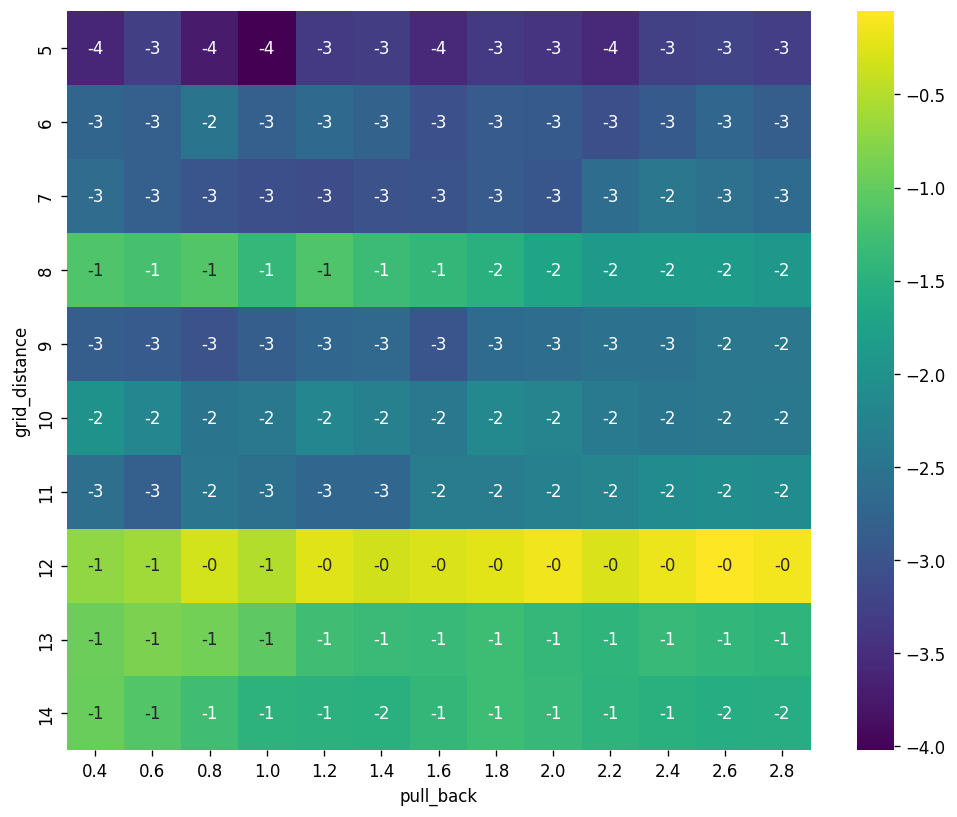

In [77]:
# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()